<a href="https://colab.research.google.com/github/123prashanth123/Fault-Detection-System/blob/main/Triplet%20Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NoteBook Setup

In [ ]:
from IPython.display import clear_output
from google.colab import drive
drive.mount("/content/gdrive")

!pip install --upgrade imgaug
!pip install imagecorruptions

clear_output()

# Imports and Constants

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim, FloatTensor
from torchvision import models, transforms, ops
from torch.utils.data import DataLoader as DL
from torch.utils.data import Dataset

import imgaug
from imgaug import augmenters
from sklearn.model_selection import KFold
from termcolor import colored

import os
import re
import cv2
import random as r
from time import time

import warnings
warnings.filterwarnings("ignore")

In [ ]:
SEED = 0
STANDARD_SIZE = 224
FV = 2048

EMBED = 128

DS_PATH = "/content/gdrive/My Drive/Videos/"


def breaker(num=50, char="*"):
    print(colored("\n" + num*char + "\n", color="red"))


def normalize(x=None):
    for i in range(x.shape[0]):
        x[i] = (x[i] - torch.min(x[i]))/(torch.max(x[i]) - torch.min(x[i]))
    return x


def timeit(func):
    start_time = time()
    func
    breaker()
    print("Time Taken : {:.2f} minutes".format((time()-start_time)/60))
    breaker()

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Build Pretrained Models

In [ ]:
def build_pretrained():
    breaker()
    print("Building Pretrained Models ...")

    class RoIExtractor(nn.Module):
        def __init__(self):
            super(RoIExtractor, self).__init__()
            self.model = models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True, progress=True)
        
        def forward(self, x):
            return self.model(x)


    class FeatureExtractor(nn.Module):
        def __init__(self):
            super(FeatureExtractor, self).__init__()

            self.model = models.resnet50(pretrained=True, progress=True)
            for params in self.model.parameters():
                params.requires_grad = False
            self.model = nn.Sequential(*[*self.model.children()][:-1])
        
        def forward(self, x):
            return self.model(x)


    roi_extractor = RoIExtractor().to(DEVICE)
    roi_extractor.eval()
    fea_extractor = FeatureExtractor().to(DEVICE)
    fea_extractor.eval()

    fea_transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                        std=[0.229, 0.224, 0.225]),
                                ]) 
    roi_transform = transforms.Compose([transforms.ToTensor(),])

    return fea_extractor, fea_transform, roi_extractor, roi_transform

# Build Dataloaders

In [ ]:
def build_loaders(idx, batch_size, num_samples, triplet=True):
    fea_extractor, fea_transform, roi_extractor, roi_transform = build_pretrained()

    breaker()
    print("Building Dataloaders ...")

    class FEDS(Dataset):
        def __init__(self, X=None, transform=None):
            self.transform = transform
            self.X = X
        
        def __len__(self):
            return self.X.shape[0]
        
        def __getitem__(self, idx):
            return self.transform(self.X[idx])
    

    def get_anchor_image_and_features(idx, size=224):
        names = [name for name in os.listdir(DS_PATH) if (name[-4:] == ".jpg")]
        image = cv2.cvtColor(cv2.imread(os.path.join(DS_PATH, names[idx]), cv2.IMREAD_COLOR), code=cv2.COLOR_BGR2RGB)
        net_image = cv2.resize(image, dsize=(size, size), interpolation=cv2.INTER_AREA)
        with torch.no_grad():
            features = fea_extractor(fea_transform(net_image).to(DEVICE).unsqueeze(dim=0))[:, :, 0, 0]
        return image, normalize(features).detach().cpu().numpy()


    def make_data(size=224, num_samples=1000, cls="Positive",
                  roi_extractor=None, fea_extractor=None, roi_transform=None, fea_transform=None, 
                  device="cpu", seed=0, feature_vector_size=512):
        image, anchor = get_anchor_image_and_features(idx, size=STANDARD_SIZE)
        image = cv2.resize(src=image, dsize=(size, size), interpolation=cv2.INTER_AREA)

        num_layers = 3
        imgaug.seed(seed)
        cropper_augment = augmenters.Sequential([augmenters.imgcorruptlike.GlassBlur(severity=(3, 5), seed=seed)] * num_layers)
        
        imgaug.seed(seed)
        dataset_augment = augmenters.Sequential([
            augmenters.HorizontalFlip(p=0.25),
            augmenters.VerticalFlip(p=0.25),
            augmenters.SomeOf(5, [
                    augmenters.blur.GaussianBlur(sigma=(0, 5), seed=seed),
                    augmenters.blur.MedianBlur(k=(1, 7), seed=seed),
                    augmenters.size.Crop(percent=(0, 0.1), seed=seed),
                    augmenters.geometric.Affine(rotate=(-45, 45), scale=(0.5, 1.2),translate_percent=(-0.2, 0.2), seed=seed),
                    augmenters.geometric.Rot90(k=(1, 3), seed=seed),
                    augmenters.arithmetic.Dropout(p=(0, 0.05), seed=seed),
                    augmenters.arithmetic.SaltAndPepper(p=(0, 0.05), seed=seed),
                    augmenters.color.MultiplyBrightness(mul=(0.5, 1.5)),
                    augmenters.color.MultiplySaturation(mul=(0, 5), seed=seed),
                    augmenters.iaa_convolutional.Sharpen(alpha=(0.75, 1), lightness=(0.75, 1.25), seed=seed),
                    augmenters.iaa_convolutional.Emboss(alpha=(0.75, 1), strength=(0.75, 1.25), seed=seed),
                    augmenters.contrast.CLAHE(seed=seed),
                    augmenters.contrast.GammaContrast(gamma=(0.2, 5), seed=seed), 
                    ])
                ])

        if re.match(r"Negative", cls, re.IGNORECASE):
            with torch.no_grad():
                output = roi_extractor(roi_transform(image).to(device).unsqueeze(dim=0))
            cnts, scrs = output[0]["boxes"], output[0]["scores"]
            if len(cnts) != 0:
                cnts = ops.clip_boxes_to_image(cnts, (image.shape[0], image.shape[1]))
                best_index = ops.nms(cnts, scrs, 0.1)[0]

                x1, y1, x2, y2 = int(cnts[best_index][0]), int(cnts[best_index][1]), int(cnts[best_index][2]), int(cnts[best_index][3])
                crp_img = image[y1:y2, x1:x2]
                crp_img = cropper_augment(images=np.expand_dims(crp_img, axis=0))
                image[y1:y2, x1:x2] = crp_img.squeeze()

        images = np.array(dataset_augment(images=[image for _ in range(num_samples)]))

        batch_size = 128
        feature_data_setup = FEDS(X=images, transform=fea_transform)
        feature_data = DL(feature_data_setup, batch_size=batch_size, shuffle=False)

        features = torch.zeros(num_samples, feature_vector_size).to(device)

        i = 0
        for X in feature_data:
            X = X.to(device)
            with torch.no_grad():
                output = fea_extractor(X)[:, :, 0, 0]
            features[i * batch_size : (i * batch_size) + output.shape[0], :] = output
            i += 1

        return images, anchor, normalize(features).detach().cpu().numpy()
    

    _, anchor, p_features = make_data(size=STANDARD_SIZE, num_samples=num_samples, cls="Positive",
                                      roi_extractor=roi_extractor, fea_extractor=fea_extractor, 
                                      roi_transform=roi_transform, fea_transform=fea_transform, 
                                      device=DEVICE, seed=SEED, feature_vector_size=FV)
    _, anchor, n_features = make_data(size=STANDARD_SIZE, num_samples=num_samples, cls="Negative",
                                      roi_extractor=roi_extractor, fea_extractor=fea_extractor, 
                                      roi_transform=roi_transform, fea_transform=fea_transform, 
                                      device=DEVICE, seed=SEED, feature_vector_size=FV)

    np.random.seed(SEED)
    class SiameseDS(Dataset):
        def __init__(self, anchor, p_vector, n_vector):
            self.anchor = anchor
            self.p_vector = p_vector
            self.n_vector = n_vector
            
        def __len__(self):
            return self.p_vector.shape[0]
            # return self.n_vector.shape[0]
        
        def __getitem__(self, idx):
            return self.anchor, self.p_vector[idx], self.n_vector[idx]
    
    class DS(Dataset):
        def __init__(self, p_vector=None, n_vector=None):
            self.X = np.concatenate((p_vector, n_vector), axis=0)
            self.y = np.concatenate((np.ones((p_vector.shape[0], 1)), np.zeros((n_vector.shape[0], 1))), axis=0)

        def __len__(self):
            return self.X.shape[0]

        def __getitem__(self, idx):
            return torch.FloatTensor(self.X[idx]), torch.FloatTensor(self.y[idx])


    kf = KFold(n_splits=5, shuffle=True, random_state=SEED).split(p_features)
    for tr_idx, va_idx in kf:
        train_indices, valid_indices = tr_idx, va_idx
        break
    p_train, p_valid = p_features[train_indices], p_features[valid_indices]
    n_train, n_valid = n_features[train_indices], n_features[valid_indices]

    if triplet:
        tr_data_setup = SiameseDS(anchor=anchor, p_vector=p_train, n_vector=n_train)
        va_data_setup = SiameseDS(anchor=anchor, p_vector=p_valid, n_vector=n_valid)
    else:
        tr_data_setup = DS(p_vector=p_train, n_vector=n_train)
        va_data_setup = DS(p_vector=p_valid, n_vector=n_valid)

    dataloaders = {"train" : DL(tr_data_setup, batch_size=batch_size, shuffle=True, generator=torch.manual_seed(SEED)),
                   "valid" : DL(va_data_setup, batch_size=batch_size, shuffle=False)
                   }

    return dataloaders

# Build Networks

In [ ]:
def build_embedder(embed=None):
    breaker()
    print("Building Embedding Network ...")

    class EmbeddingNetwork(nn.Module):
        def __init__(self, IL=2048, embed=None):
            super(EmbeddingNetwork, self).__init__()

            self.embedder = nn.Sequential()
            self.embedder.add_module("BN", nn.BatchNorm1d(num_features=IL, eps=1e-5))
            self.embedder.add_module("FC", nn.Linear(in_features=IL, out_features=embed))
            self.embedder.add_module("AN", nn.ReLU())
        
        def getOptimizer(self, lr=1e-3, wd=0):
            return optim.Adam(self.parameters(), lr=lr, weight_decay=wd)
    
        def forward(self, x1, x2=None, x3=None):
            if x2 is not None and x3 is not None:
                x1 = self.embedder(x1)
                x2 = self.embedder(x2)
                x3 = self.embedder(x3)
                return x1, x2, x3
            else:
                return self.embedder(x1)
    
    model = EmbeddingNetwork(embed=embed)
    return model

def build_classifier(embedding_net=None, path=None, embed=None):
    embedding_net.load_state_dict(torch.load(os.path.join(path, "embedder_state.pt"), map_location=DEVICE)["model_state_dict"])
    embedding_net.eval()
    for params in embedding_net.parameters():
        params.requires_grad = False
    
    breaker()
    print("Building Classifier ...")

    class Network(nn.Module):
        def __init__(self, embedding_net=None, embed=embed):
            super(Network, self).__init__()

            self.embedding_net = embedding_net
        
            self.classifier = nn.Sequential()
            self.classifier.add_module("BN", nn.BatchNorm1d(num_features=embed, eps=1e-5))
            self.classifier.add_module("FC", nn.Linear(in_features=embed, out_features=1))
            self.classifier.add_module("AN", nn.ReLU())
        
        def getOptimizer(self, lr=1e-3, wd=0):
            p = [p for p in self.parameters() if p.requires_grad]
            return optim.Adam(p, lr=lr, weight_decay=wd)
    
        def forward(self, x):
            return self.classifier(self.embedding_net(x))
    
    model = Network(embedding_net=embedding_net, embed=embed)
    return model

# Embedder Trainer

In [ ]:
def train_embedder(model, tr_data, va_data, epochs, lr, wd):

    def fit_(model=None, optimizer=None, scheduler=None, epochs=None,
             trainloader=None, validloader=None, criterion=None, device=None,
             path=None, verbose=None):
        breaker()
        print("Training ...")
        breaker()

        model.to(device)
        Losses, Accuracies = [], []
        bestLoss = {"train" : np.inf, "valid" : np.inf}
        DLS = {"train" : trainloader, "valid" : validloader}

        start_time = time()
        for e in range(epochs):
            e_st = time()
            epochLoss = {"train" : 0.0, "valid" : 0.0}

            for phase in ["train", "valid"]:
                if phase == "train":
                    model.train()
                else:
                    model.eval()
                
                lossPerPass = []

                for A, P, N in DLS[phase]:
                    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == "train"):
                        op_A, op_P, op_N = model(A.squeeze(), P, N)
                        loss = criterion(op_A, op_P, op_N)
                        if phase == "train":
                            loss.backward()
                            optimizer.step()
                    lossPerPass.append(loss.item())
                epochLoss[phase] = np.mean(np.array(lossPerPass))
            Losses.append(epochLoss)
            
            if epochLoss["valid"] < bestLoss["valid"]:
                bestLoss = epochLoss
                BLE = e+1
                torch.save({"model_state_dict" : model.state_dict(),
                            "optim_state_dict" : optimizer.state_dict()},
                            os.path.join(path, "embedder_state.pt"))
            if scheduler:
                scheduler.step(epochLoss["valid"])
            
            if verbose:
                print("Epoch: {} | Train Loss: {:.5f} | Valid Loss: {:.5f} | Time: {:.2f} seconds".format(e + 1, epochLoss["train"], epochLoss["valid"], time() - e_st))

        breaker()
        print("Best Validation Loss at Epoch ---> {}".format(BLE))
        breaker()
        print("Time Taken [{} Epochs] : {:.2f} minutes".format(epochs, (time() - start_time) / 60))
        breaker()
        print("Training Completed")
        breaker()

        return Losses, BLE
    
    optimizer = model.getOptimizer(lr=lr, wd=wd)
    checkpoint_path = os.path.join("/content/embedder_checkpoints")
    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path)

    L, BLE = fit_(model=model, optimizer=optimizer, scheduler=None, epochs=epochs,
                  trainloader=tr_data, validloader=va_data, device=DEVICE,
                  criterion=nn.TripletMarginLoss(margin=1.0), 
                  path=checkpoint_path, verbose=True)

    TL, VL = [], []

    for i in range(len(L)):
        TL.append(L[i]["train"])
        VL.append(L[i]["valid"])

    x_Axis = np.arange(1, len(L)+1)
    plt.figure(figsize=(8, 5))
    plt.plot(x_Axis, TL, "r", label="Training Loss")
    plt.plot(x_Axis, VL, "b--", label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

    return BLE, checkpoint_path

# Classifier Trainer

In [ ]:
def train_classifier(model, tr_data, va_data, epochs, lr, wd):

    def fit_(model=None, optimizer=None, scheduler=None, epochs=None,
             trainloader=None, validloader=None, criterion=None, device=None,
             path=None, verbose=None):
        breaker()
        print("Training ...")
        breaker()

        model.to(device)
        Losses, Accuracies = [], []
        bestLoss, bestAccs = {"train" : np.inf, "valid" : np.inf}, {"train" : 0.0, "valid" : 0.0}
        DLS = {"train" : trainloader, "valid" : validloader}

        start_time = time()
        for e in range(epochs):
            e_st = time()
            epochLoss = {"train" : 0.0, "valid" : 0.0}
            epochAccs = {"train" : 0.0, "valid" : 0.0}

            for phase in ["train", "valid"]:
                if phase == "train":
                    model.train()
                else:
                    model.eval()
                
                lossPerPass, accsPerPass = [], []

                for X, y in DLS[phase]:
                    X, y = X.to(device), y.to(device)

                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == "train"):
                        output = model(X)
                        loss = criterion(output, y)
                        if phase == "train":
                            loss.backward()
                            optimizer.step()
                    lossPerPass.append(loss.item())
                    accsPerPass.append(getAccuracy(output, y))
                epochLoss[phase] = np.mean(np.array(lossPerPass))
                epochAccs[phase] = np.mean(np.array(accsPerPass))
            Losses.append(epochLoss)
            Accuracies.append(epochAccs)
            
            if epochLoss["valid"] < bestLoss["valid"]:
                bestLoss = epochLoss
                BLE = e+1
                torch.save({"model_state_dict" : model.state_dict(),
                            "optim_state_dict" : optimizer.state_dict()},
                            os.path.join(path, "classifier_state.pt"))
            
            if epochAccs["valid"] > bestAccs["valid"]:
                bestAccs = epochAccs
                BAE = e+1
            
            if scheduler:
                scheduler.step(epochLoss["valid"])
            
            if verbose:
                print("Epoch: {} | Train Loss: {:.5f} | Valid Loss: {:.5f} | Train Accs : {:.5f} | \
Valid Accs : {:.5f} | Time: {:.2f} seconds".format(e + 1,
                                                    epochLoss["train"], epochLoss["valid"],
                                                    epochAccs["train"], epochAccs["valid"],
                                                    time() - e_st))



        breaker()
        print("Best Validation Loss at Epoch ---> {}".format(BLE))
        breaker()
        print("Best Validation Accs at Epoch ---> {}".format(BAE))
        breaker()
        print("Time Taken [{} Epochs] : {:.2f} minutes".format(epochs, (time() - start_time) / 60))
        breaker()
        print("Training Completed")
        breaker()

        return Losses, Accuracies, BLE, BAE


    def getAccuracy(y_pred=None, y_true=None):
        y_pred, y_true = torch.sigmoid(y_pred).detach(), y_true.detach()

        y_pred[y_pred > 0.5] = 1
        y_pred[y_pred <= 0.5] = 0

        return torch.count_nonzero(y_pred == y_true).item() / len(y_pred)
    
    optimizer = model.getOptimizer(lr=lr, wd=wd)
    checkpoint_path = os.path.join("/content/classifier_checkpoints")
    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path)

    L, A, BLE, BAE = fit_(model=model, optimizer=optimizer, scheduler=None, epochs=epochs,
                          trainloader=tr_data, validloader=va_data, device=DEVICE,
                          criterion=nn.BCEWithLogitsLoss(),
                          path=checkpoint_path, verbose=True)

    TL, VL, TA, VA = [], [], [], []

    for i in range(len(L)):
        TL.append(L[i]["train"])
        VL.append(L[i]["valid"])
        TA.append(A[i]["train"])
        VA.append(A[i]["valid"])

    x_Axis = np.arange(1, len(L)+1)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(x_Axis, TL, "r", label="Training Loss")
    plt.plot(x_Axis, VL, "b--", label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.plot(x_Axis, TA, "r", label="Training Accuracy")
    plt.plot(x_Axis, VA, "b--", label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

    return BLE, checkpoint_path

# Main


**************************************************

Building Pretrained Models ...

**************************************************

Building Dataloaders ...

**************************************************

Building Embedding Network ...

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.25745 | Valid Loss: 0.72538 | Time: 0.23 seconds
Epoch: 2 | Train Loss: 1.23371 | Valid Loss: 0.74150 | Time: 0.22 seconds
Epoch: 3 | Train Loss: 1.21139 | Valid Loss: 0.73274 | Time: 0.21 seconds
Epoch: 4 | Train Loss: 1.18611 | Valid Loss: 0.72548 | Time: 0.21 seconds
Epoch: 5 | Train Loss: 1.16374 | Valid Loss: 0.72153 | Time: 0.22 seconds
Epoch: 6 | Train Loss: 1.14199 | Valid Loss: 0.71425 | Time: 0.23 seconds
Epoch: 7 | Train Loss: 1.11767 | Valid Loss: 0.70707 | Time: 0.22 seconds
Epoch: 8 | Train Loss: 1.09885 | Valid Loss: 0.69599 | Time: 0.23 seconds
Epoch: 9 | Train Loss: 1.07410 | Valid Loss

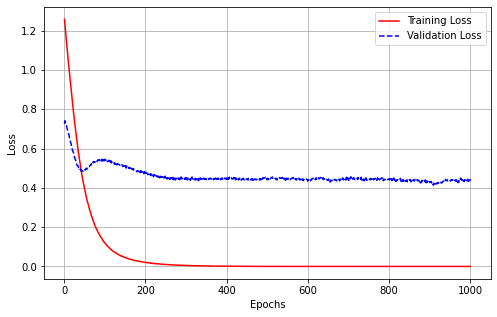


**************************************************

Building Pretrained Models ...

**************************************************

Building Dataloaders ...

**************************************************

Building Classifier ...

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.68764 | Valid Loss: 0.66617 | Train Accs : 0.58386 | Valid Accs : 0.65848 | Time: 0.37 seconds
Epoch: 2 | Train Loss: 0.64502 | Valid Loss: 0.62515 | Train Accs : 0.68597 | Valid Accs : 0.71982 | Time: 0.35 seconds
Epoch: 3 | Train Loss: 0.61153 | Valid Loss: 0.59969 | Train Accs : 0.72607 | Valid Accs : 0.73661 | Time: 0.35 seconds
Epoch: 4 | Train Loss: 0.58820 | Valid Loss: 0.58301 | Train Accs : 0.74127 | Valid Accs : 0.75036 | Time: 0.36 seconds
Epoch: 5 | Train Loss: 0.57464 | Valid Loss: 0.57153 | Train Accs : 0.75928 | Valid Accs : 0.76696 | Time: 0.36 seconds
Epoch: 6 | Train Loss: 0.56414 | Valid Los

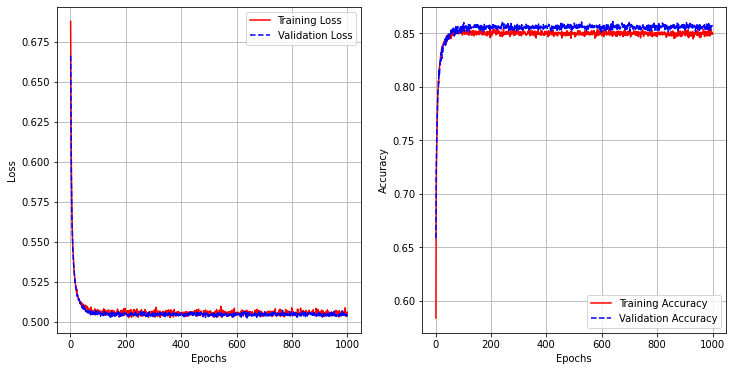

In [ ]:
def main():
    ###
    num_samples = 10000
    batch_size = 512
    epochs = 1000
    e_lr, e_wd = 1e-6, 1e-6
    c_lr, c_wd = 1e-3, 1e-5
    ###

    dataloaders = build_loaders(1, batch_size=batch_size, num_samples=num_samples, triplet=True)
    embedder = build_embedder(embed=EMBED)
    _, path = train_embedder(embedder, dataloaders["train"], dataloaders["valid"], epochs, e_lr, e_wd)

    dataloaders = build_loaders(1, batch_size=batch_size, num_samples=num_samples, triplet=False)
    classifier = build_classifier(embedder, path, embed=EMBED)
    _, path = train_classifier(classifier, dataloaders["train"], dataloaders["valid"], epochs, c_lr, c_wd)

    return classifier, path

classifier, path = main()